# Final Project - Basics of deep learning
Hello dear students,<br> This is the template notebook. Please copy it into your drive.

---
<br>

### Name and ID:
Student 1: Ofir Gur Cohen 206588642
<br>
Student 2: Oz Gemer 208426460

Prior to conducting any experiment, kindly execute the import statements and notebook function to ensure smooth and error-free execution.

# Import and functions

## Imports

In [ ]:
!pip install --upgrade --no-cache-dir gdown
!gdown --id 1PCQCO6TOKo-9jJYHqRj_3YfzthGPAIuX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1PCQCO6TOKo-9jJYHqRj_3YfzthGPAIuX
To: /content/explainer.md
100% 1.62k/1.62k [00:00<00:00, 3.61MB/s]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from torch.utils.data import ConcatDataset
from torch.utils.data import TensorDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset,Subset
import torchvision
import torchvision.transforms as transforms
import time
import copy
from google.colab import files
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms, models
from tqdm import tqdm
import random
from torchvision import models
from torch.utils.data import Subset

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## Functions

In [ ]:
%%script echo skipping
def train_val_dataset(dataset, val_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

def test_split_to_validation(dataset, val_split=0.25):
    test_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['test'] = Subset(dataset, test_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

In [ ]:
%%script echo skipping
def draw_graph(train,val,label):
  plt.plot(train,color='b',label='train',linestyle='--'),plt.plot(val,color='r',label='val')
  plt.xlabel('epochs')
  plt.ylabel(label)
  plt.legend()

def train_vs_val(train_results, val_results, label):
  train = []
  for item in train_results:
    train.append(item[1].item() if label== 'accuracy' else item[0])

  val = []
  for item in val_results:
    val.append(item[1].item() if label == 'accuracy' else item[0])

  draw_graph(train, val, label)

def val_vs_train(train_results, val_results, label):
  train = []
  for item in train_results:
    train.append(item)

  val = []
  for item in val_results:
    val.append(item)

  draw_graph(train, val, label)


# Experiment 1 - 5 layers

## Introduction to the experiment

The objective of this experiment is to construct a CNN consisting of 5 convolution layers, employing 3 fully connected layers alongside maxpooling and a Relu activation function. The optimization technique utilized in this study is SGD, and the cross-entropy loss function is employed.

## Pre-processing our data

### Data augmentation

In [ ]:
%%script echo skipping
transform_train = transforms.Compose([
    transforms.Resize((224, 224,)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224,)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

### importing dataset and appling transformation


Downloading StanfordCars for our dataset

In [ ]:
%%script echo skipping
trainset = torchvision.datasets.StanfordCars(root='./data', split='train', download=True, transform=transform_train)
testset = torchvision.datasets.StanfordCars(root='./data', split='test', download=True, transform=transform_test)

  0%|          | 0/330960 [00:00<?, ?it/s]

Extracting data/stanford_cars/car_devkit.tgz to data/stanford_cars


  0%|          | 0/979269282 [00:00<?, ?it/s]

Extracting data/stanford_cars/cars_train.tgz to data/stanford_cars
Using downloaded and verified file: data/stanford_cars/car_devkit.tgz
Extracting data/stanford_cars/car_devkit.tgz to data/stanford_cars


  0%|          | 0/977350468 [00:00<?, ?it/s]

Extracting data/stanford_cars/cars_test.tgz to data/stanford_cars


  0%|          | 0/185758 [00:00<?, ?it/s]

In [ ]:
%%script echo skipping
datasets = test_split_to_validation(testset)

testset = datasets['test']
valset = datasets['val']

In [ ]:
%%script echo skipping
batchsize = 32

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,
                                          shuffle=True)

valloader = torch.utils.data.DataLoader(valset, batch_size=batchsize,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize,
                                         shuffle=False)

## Net architecture

The architecture comprises of 5 convolutional layers initialized with 32 filters and kernel size of 3. The subsequent layers follow suit in a similar fashion, each applying max pooling and Relu activation function. Finally, fully connected layers are employed to complete the network.

In [ ]:
%%script echo skipping
class CNN1(nn.Module):

    def __init__(self):

        super().__init__()

        self.Convolution1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.Convolution2 = nn.Conv2d(32, 64, kernel_size=4, stride=1, padding=1)
        self.Convolution3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.Convolution4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.Convolution5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

        self.MaxPooling = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.FullyConnected1 = torch.nn.Linear(9216, 1024) # 256 x 6 x 6 = 9216
        self.FullyConnected2 = torch.nn.Linear(1024, 512)
        self.FullyConnected3 = torch.nn.Linear(512, 196)

        self.ReLU = torch.nn.ReLU()

    def forward(self, x):
        x = self.ReLU(self.Convolution1(x))
        x = self.MaxPooling(x)
        x = self.ReLU(self.Convolution2(x))
        x = self.MaxPooling(x)
        x = self.ReLU(self.Convolution3(x))
        x = self.MaxPooling(x)
        x = self.ReLU(self.Convolution4(x))
        x = self.MaxPooling(x)
        x = self.ReLU(self.Convolution5(x))
        x = self.MaxPooling(x)
        x = torch.flatten(x,1)
        x = self.ReLU(self.FullyConnected1(x))
        x = self.ReLU(self.FullyConnected2(x))
        x = self.FullyConnected3(x)
        return x


Net architecture

In [ ]:
%%script echo skipping
net = CNN1().cuda()

print(net)

CNN1(
  (Convolution1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Convolution2): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (Convolution3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Convolution4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Convolution5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (MaxPooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (FullyConnected1): Linear(in_features=9216, out_features=1024, bias=True)
  (FullyConnected2): Linear(in_features=1024, out_features=512, bias=True)
  (FullyConnected3): Linear(in_features=512, out_features=196, bias=True)
  (ReLU): ReLU()
)


## Net hyper parameters

In [ ]:
%%script echo skipping
criterion = nn.CrossEntropyLoss()

In [ ]:
%%script echo skipping
optimizer = torch.optim.SGD(net.parameters(), lr=0.005, momentum=0.9)

## Net training stage

In [ ]:
%%script echo skipping
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%script echo skipping
max_acc = 0

train_loss = []
train_acc = []

val_loss = []
val_acc = []

epochs = 30

for epoch in tqdm(range(epochs)):

    train_running_loss = 0.0
    train_running_corrects = 0

    val_running_loss = 0.0
    val_running_corrects = 0

    net.train()
    for i, data in enumerate(trainloader, 0):

        inputs, labels = data

        inputs = inputs.cuda()
        labels = labels.cuda()


        optimizer.zero_grad()


        outputs = net(inputs)

        _, preds = torch.max(outputs, 1)
        train_running_corrects += torch.sum(preds == labels.data)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        # print statistics
        train_running_loss += (loss.item())

    net.eval()
    with torch.no_grad():
      for i, data in enumerate(valloader, 0):

          inputs, labels = data

          inputs = inputs.cuda()
          labels = labels.cuda()

          optimizer.zero_grad()

          outputs = net(inputs)

          _, preds = torch.max(outputs, 1)
          val_running_corrects += torch.sum(preds == labels.data)

          loss = criterion(outputs, labels)

          val_running_loss += (loss.item())


    train_loss.append(train_running_loss/len(trainloader))
    epoch_train_acc = train_running_corrects.double() / len(trainset)
    train_acc.append(epoch_train_acc.item())


    val_loss.append(val_running_loss/len(valloader))
    epoch_val_acc = val_running_corrects.double() / len(valset)
    val_acc.append(epoch_val_acc.item())

        # deep copy the model (Early Stopping) and Saving our model, when we get best accuracy
    if epoch_val_acc.item() > max_acc:
        max_acc = epoch_val_acc.item()
        current_best_model = copy.deepcopy(net.state_dict())
        path = "/content/drive/MyDrive/CNN1Model.pt"
        torch.save(net.state_dict(), path)
    max_acc = max(max_acc,epoch_train_acc.item())

    print('')
    print('epoch number:',epoch)
    print('Train acc:',epoch_train_acc.item(), ' Train loss:',train_running_loss/len(trainloader))
    print('Val acc:',epoch_val_acc.item(), ' Val loss:',val_running_loss/len(valloader))

net.load_state_dict(current_best_model)
print('Finished Training')

  3%|▎         | 1/30 [02:45<1:20:13, 165.99s/it]


epoch number: 0
Train acc: 0.003806483300589391  Train loss: 5.279205247467639
Val acc: 0.0069617105917453995  Val loss: 5.277590918162512


  7%|▋         | 2/30 [05:18<1:13:47, 158.14s/it]


epoch number: 1
Train acc: 0.006507858546168958  Train loss: 5.278013915641635
Val acc: 0.004475385380407757  Val loss: 5.276456053294833


 10%|█         | 3/30 [07:49<1:09:35, 154.67s/it]


epoch number: 2
Train acc: 0.008349705304518663  Train loss: 5.276940570158117
Val acc: 0.004475385380407757  Val loss: 5.275324178120447


 13%|█▎        | 4/30 [10:20<1:06:25, 153.27s/it]


epoch number: 3
Train acc: 0.008349705304518663  Train loss: 5.275415527119356
Val acc: 0.004475385380407757  Val loss: 5.272694133576893


 17%|█▋        | 5/30 [12:51<1:03:36, 152.66s/it]


epoch number: 4
Train acc: 0.008226915520628684  Train loss: 5.271170909731996
Val acc: 0.004475385380407757  Val loss: 5.263284599970257


 20%|██        | 6/30 [15:25<1:01:08, 152.84s/it]


epoch number: 5
Train acc: 0.008840864440078585  Train loss: 5.251793543497722
Val acc: 0.008950770760815513  Val loss: 5.223534440237378


 23%|██▎       | 7/30 [17:56<58:27, 152.50s/it]  


epoch number: 6
Train acc: 0.013629666011787818  Train loss: 5.210421837077421
Val acc: 0.014420686225758327  Val loss: 5.187868549710228


 27%|██▋       | 8/30 [20:28<55:51, 152.36s/it]


epoch number: 7
Train acc: 0.013629666011787818  Train loss: 5.1602292004753565
Val acc: 0.013923421183490799  Val loss: 5.158320623730856


 30%|███       | 9/30 [23:00<53:13, 152.07s/it]


epoch number: 8
Train acc: 0.01805009823182711  Train loss: 5.10396406884287
Val acc: 0.014917951268025857  Val loss: 5.109224728175572


 33%|███▎      | 10/30 [25:33<50:48, 152.44s/it]


epoch number: 9
Train acc: 0.022224950884086443  Train loss: 5.01975440231024
Val acc: 0.028344107409249128  Val loss: 5.048028900509789


 37%|███▋      | 11/30 [28:06<48:18, 152.57s/it]


epoch number: 10
Train acc: 0.02799607072691552  Train loss: 4.931971660314821
Val acc: 0.02486325211337643  Val loss: 5.056136721656436


 40%|████      | 12/30 [30:35<45:26, 151.47s/it]


epoch number: 11
Train acc: 0.03413555992141454  Train loss: 4.835324925067378
Val acc: 0.028841372451516654  Val loss: 5.0219650192866245


 43%|████▎     | 13/30 [33:04<42:42, 150.72s/it]


epoch number: 12
Train acc: 0.04960707269155206  Train loss: 4.715622944925346
Val acc: 0.02734957732471407  Val loss: 5.055622630649143


 47%|████▋     | 14/30 [35:31<39:53, 149.62s/it]


epoch number: 13
Train acc: 0.062254420432220035  Train loss: 4.574143514446184
Val acc: 0.028841372451516654  Val loss: 5.023719189658998


 50%|█████     | 15/30 [38:00<37:20, 149.39s/it]


epoch number: 14
Train acc: 0.07662082514734773  Train loss: 4.385251149944231
Val acc: 0.03530581800099453  Val loss: 5.130929621439131


 53%|█████▎    | 16/30 [40:29<34:52, 149.45s/it]


epoch number: 15
Train acc: 0.11075638506876227  Train loss: 4.138757986180923
Val acc: 0.04375932371954251  Val loss: 5.067631524706644


 57%|█████▋    | 17/30 [42:58<32:20, 149.25s/it]


epoch number: 16
Train acc: 0.1475933202357564  Train loss: 3.8260951032825545
Val acc: 0.04475385380407757  Val loss: 5.0364406373765735


 60%|██████    | 18/30 [45:28<29:51, 149.28s/it]


epoch number: 17
Train acc: 0.2147593320235756  Train loss: 3.4165842224569882
Val acc: 0.03779214321233217  Val loss: 5.457292844378759


 63%|██████▎   | 19/30 [47:57<27:21, 149.25s/it]


epoch number: 18
Train acc: 0.29813359528487227  Train loss: 2.9622160888185687
Val acc: 0.042267528592739925  Val loss: 5.908061723860484


 67%|██████▋   | 20/30 [50:26<24:53, 149.37s/it]


epoch number: 19
Train acc: 0.40471512770137524  Train loss: 2.455425814553803
Val acc: 0.04425658876181004  Val loss: 6.040991003551181


 70%|███████   | 21/30 [52:57<22:27, 149.73s/it]


epoch number: 20
Train acc: 0.5038064833005893  Train loss: 1.9732584392323214
Val acc: 0.04624564893088016  Val loss: 6.9792530498807395


 73%|███████▎  | 22/30 [55:27<19:57, 149.70s/it]


epoch number: 21
Train acc: 0.6046168958742633  Train loss: 1.579148347938762
Val acc: 0.04027846842366981  Val loss: 7.336917400360107


 77%|███████▋  | 23/30 [57:55<17:25, 149.37s/it]


epoch number: 22
Train acc: 0.6791502946954813  Train loss: 1.2223812437524983
Val acc: 0.04375932371954251  Val loss: 7.955556362394303


 80%|████████  | 24/30 [1:00:24<14:54, 149.17s/it]


epoch number: 23
Train acc: 0.75  Train loss: 0.9457684019032646
Val acc: 0.04724017901541521  Val loss: 9.001785369146438


 83%|████████▎ | 25/30 [1:02:53<12:26, 149.24s/it]


epoch number: 24
Train acc: 0.8089390962671905  Train loss: 0.7137267861296149
Val acc: 0.04475385380407757  Val loss: 9.172752925327845


 87%|████████▋ | 26/30 [1:05:24<09:58, 149.65s/it]


epoch number: 25
Train acc: 0.8528978388998035  Train loss: 0.541674467103154
Val acc: 0.051218299353555444  Val loss: 9.884458057464116


 90%|█████████ | 27/30 [1:07:53<07:28, 149.52s/it]


epoch number: 26
Train acc: 0.8763506876227897  Train loss: 0.45787397830509674
Val acc: 0.03928393833913475  Val loss: 11.476277048625644


 93%|█████████▎| 28/30 [1:10:22<04:58, 149.43s/it]


epoch number: 27
Train acc: 0.8817534381139489  Train loss: 0.43998159041591717
Val acc: 0.05271009448035802  Val loss: 10.07399142734588


 97%|█████████▋| 29/30 [1:12:52<02:29, 149.48s/it]


epoch number: 28
Train acc: 0.9241159135559921  Train loss: 0.2829942223049846
Val acc: 0.04624564893088016  Val loss: 9.774390175229026


100%|██████████| 30/30 [1:15:22<00:00, 150.74s/it]


epoch number: 29
Train acc: 0.9336935166994106  Train loss: 0.25933782774955033
Val acc: 0.050223769269020384  Val loss: 11.102605327727302
Finished Training


## Our visual result of the train stage

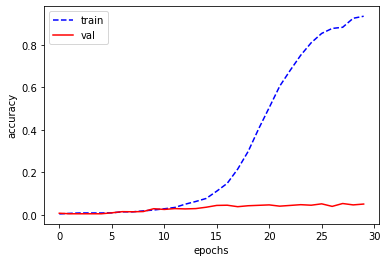

In [ ]:
%%script echo skipping
val_vs_train(train_acc, val_acc, 'accuracy')

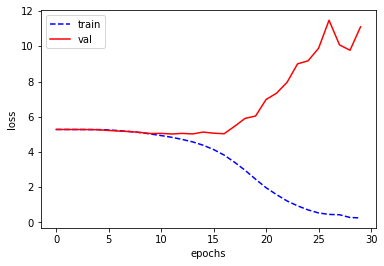

In [ ]:
%%script echo skipping
val_vs_train(train_loss, val_loss, 'loss')

## Net testing stage

Testing our model using downloaded wights, testing without running the train section

Remove the comments to run the model test without training.

In [ ]:
%%script echo skipping
# !pip install --upgrade --no-cache-dir gdown
# !gdown --id 1ZI2WWurZctniXR9wtf2KVTW1IoTkgOqr
# net = CNN1().cuda()
# net.load_state_dict(torch.load('CNN1Model.pt'))
# net.eval()
# net.cuda()

In [ ]:
%%script echo skipping
correct = 0
total = 0

test_acc = []
test_samples = []
i = 1

test_preds = []
true_labels = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()

        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        test_preds.append(predicted.cpu().numpy())
        true_labels.append(labels.cpu().numpy())

        if i%10 == 0:
          test_acc.append(100 * correct / total)
          test_samples.append(i * batchsize)
        i += 1
    test_acc.append(100 * correct / total)
    test_samples.append(i * batchsize)

    y_pred = np.concatenate(test_preds)
    y_true = np.concatenate(true_labels)


print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 2 %


## Our visual result of the test

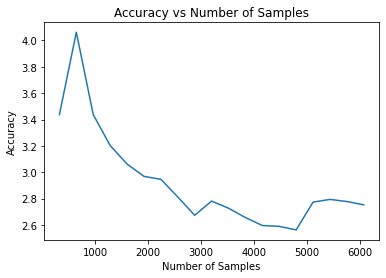

In [ ]:
%%script echo skipping
plt.plot(test_samples, test_acc)
plt.xlabel('Number of Samples')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Samples')
plt.show()

## How our model performed

The performance evaluation of the net using several metrics: F1 score, recall, accuracy, and precision score.

In [ ]:
%%script echo skipping
from sklearn.metrics import f1_score

# # Calculate the F1 score
f1 = f1_score(y_true, y_pred,average='macro')

print("F1 score: ", f1)


F1 score:  0.01585710517073497


In [ ]:
%%script echo skipping
from sklearn.metrics import recall_score

# Calculate the recall score
recall = recall_score(y_true, y_pred,average='macro')

print("Recall score: ", recall)


Recall score:  0.02782010656710719


In [ ]:
%%script echo skipping
from sklearn.metrics import precision_score

# Calculate the precision score
precision = precision_score(y_true, y_pred,average='macro')

print("Precision score: ", precision)


Precision score:  0.022592628934395793


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
%%script echo skipping
from sklearn.metrics import accuracy_score

# Calculate the accuracy score
accuracy = accuracy_score(y_true, y_pred)

print("Accuracy score: ", accuracy)


Accuracy score:  0.027529021558872307


## How our decisions affected the model

The present analysis reveals that the neural network model has undergone overfitting to the training dataset. This outcome can be primarily attributed to the deployment of an excessively low learning rate and an excessive number of convolutional filters within the CNN architecture.

## Comparison between our models

In [ ]:
%%script echo skipping
Train_final_accuracy = train_acc[-1]
Val_final_accuracy = val_acc[-1]
Test_final_accuracy = accuracy

Model1 = [Train_final_accuracy,Val_final_accuracy,Test_final_accuracy]

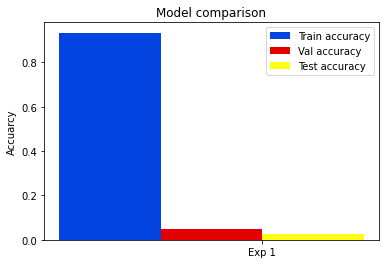

In [ ]:
%%script echo skipping
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()

Models = ['Exp 1']
x = np.arange(len(Models))

width = 5

ax.bar(x - 3*width/2, Model1[0], width, label='Train accuracy', color='#0343df')
ax.bar(x - width/2, Model1[1], width, label='Val accuracy', color='#e50000')
ax.bar(x + width/2, Model1[2], width, label='Test accuracy', color='#ffff14')

ax.set_ylabel('Accuarcy')
ax.set_title('Model comparison')
ax.set_xticks(x)
ax.set_xticklabels(Models, rotation='horizontal')
ax.legend()

plt.show()

# Experiment 2 - 4 layers with less filters

## Introduction to the experiment

The present experiment involves the upscaling of image size to 300 x 300 pixels, along with the integration of four convolutional layers and an increased learning rate. The primary objective of this experiment is to mitigate overfitting of the model to the training dataset.

## Pre-processing our data

### Data augmentation

In [ ]:
%%script echo skipping
transform_train = transforms.Compose([
    transforms.Resize((300, 300,)),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.ColorJitter(0,0.3),
    transforms.RandomResizedCrop(300),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((300, 300,)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


### importing dataset and appling transformation


In [ ]:
%%script echo skipping
trainset = torchvision.datasets.StanfordCars(root='./data', split='train', download=True, transform=transform_train)
testset = torchvision.datasets.StanfordCars(root='./data', split='test', download=True, transform=transform_test)

  0%|          | 0/330960 [00:00<?, ?it/s]

Extracting data/stanford_cars/car_devkit.tgz to data/stanford_cars


  0%|          | 0/979269282 [00:00<?, ?it/s]

Extracting data/stanford_cars/cars_train.tgz to data/stanford_cars
Using downloaded and verified file: data/stanford_cars/car_devkit.tgz
Extracting data/stanford_cars/car_devkit.tgz to data/stanford_cars


  0%|          | 0/977350468 [00:00<?, ?it/s]

Extracting data/stanford_cars/cars_test.tgz to data/stanford_cars


  0%|          | 0/185758 [00:00<?, ?it/s]

In [ ]:
%%script echo skipping
datasets = test_split_to_validation(testset)

testset = datasets['test']
valset = datasets['val']

In [ ]:
%%script echo skipping
batchsize = 32

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,
                                          shuffle=True)

valloader = torch.utils.data.DataLoader(valset, batch_size=batchsize,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize,
                                         shuffle=False)

## Net architecture

The ensuing architecture incorporates 4 convolutional layers initialized with a reduced number of filters, alongside three fully connected layers, max pooling, and a relu activation function.

In [ ]:
class CNN2(nn.Module):

    def __init__(self):
        super().__init__()

        self.Convolution1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.Convolution2 = nn.Conv2d(32, 64, kernel_size=2, stride=1, padding=1)
        self.Convolution3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.Convolution4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)

        self.MaxPooling = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.FullyConnected1 = torch.nn.Linear(41472, 2048) # 128 x 18 x 18 = 41472
        self.FullyConnected2 = torch.nn.Linear(2048, 512)
        self.FullyConnected3 = torch.nn.Linear(512, 196)

        self.ReLU = torch.nn.ReLU()

    def forward(self, x):
        x = self.ReLU(self.Convolution1(x))
        x = self.MaxPooling(x)
        x = self.ReLU(self.Convolution2(x))
        x = self.MaxPooling(x)
        x = self.ReLU(self.Convolution3(x))
        x = self.MaxPooling(x)
        x = self.ReLU(self.Convolution4(x))
        x = self.MaxPooling(x)
        x = torch.flatten(x,1)
        x = self.ReLU(self.FullyConnected1(x))
        x = self.ReLU(self.FullyConnected2(x))
        x = self.FullyConnected3(x)
        return x

In [ ]:
%%script echo skipping
net = CNN2().cuda()
print(net)

CNN2(
  (Convolution1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Convolution2): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (Convolution3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Convolution4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (MaxPooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (FullyConnected1): Linear(in_features=41472, out_features=2048, bias=True)
  (FullyConnected2): Linear(in_features=2048, out_features=512, bias=True)
  (FullyConnected3): Linear(in_features=512, out_features=196, bias=True)
  (ReLU): ReLU()
)


## Net hyper parameters

In [ ]:
%%script echo skipping
criterion = nn.CrossEntropyLoss()

In [ ]:
%%script echo skipping
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

## Net training stage

In [ ]:
%%script echo skipping
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%script echo skipping
max_acc = 0

train_loss = []
train_acc = []

val_loss = []
val_acc = []

epochs = 40

for epoch in tqdm(range(epochs)):

    train_running_loss = 0.0
    train_running_corrects = 0

    val_running_loss = 0.0
    val_running_corrects = 0

    net.train()
    for i, data in enumerate(trainloader, 0):

        inputs, labels = data

        inputs = inputs.cuda()
        labels = labels.cuda()


        optimizer.zero_grad()


        outputs = net(inputs)

        _, preds = torch.max(outputs, 1)
        train_running_corrects += torch.sum(preds == labels.data)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        # print statistics
        train_running_loss += (loss.item())

    net.eval()
    with torch.no_grad():
      for i, data in enumerate(valloader, 0):

          inputs, labels = data

          inputs = inputs.cuda()
          labels = labels.cuda()


          optimizer.zero_grad()


          outputs = net(inputs)

          _, preds = torch.max(outputs, 1)
          val_running_corrects += torch.sum(preds == labels.data)

          loss = criterion(outputs, labels)

          val_running_loss += (loss.item())


    train_loss.append(train_running_loss/len(trainloader))
    epoch_train_acc = train_running_corrects.double() / len(trainset)
    train_acc.append(epoch_train_acc.item())


    val_loss.append(val_running_loss/len(valloader))
    epoch_val_acc = val_running_corrects.double() / len(valset)
    val_acc.append(epoch_val_acc.item())

        # deep copy the model (Early Stopping) and Saving our model, when we get best accuracy
    if epoch_val_acc.item() >= max_acc:
        max_acc = epoch_val_acc.item()
        current_best_model = copy.deepcopy(net.state_dict())
        path = "/content/drive/MyDrive/CNN2Model.pt"
        torch.save(net.state_dict(), path)

    print('')
    print('epoch number:',epoch)
    print('Train acc:',epoch_train_acc.item(), ' Train loss:',train_running_loss/len(trainloader))
    print('Val acc:',epoch_val_acc.item(), ' Val loss:',val_running_loss/len(valloader))

net.load_state_dict(current_best_model)

print('Finished Training')

  2%|▎         | 1/40 [03:28<2:15:12, 208.01s/it]


epoch number: 0
Train acc: 0.0027013752455795677  Train loss: 5.279952451294544
Val acc: 0.007956240676280457  Val loss: 5.2764195336235895


  5%|▌         | 2/40 [06:36<2:04:22, 196.37s/it]


epoch number: 1
Train acc: 0.007612966601178782  Train loss: 5.277377640967275
Val acc: 0.008453505718547985  Val loss: 5.272293522244408


  8%|▊         | 3/40 [09:44<1:58:48, 192.66s/it]


epoch number: 2
Train acc: 0.009209233791748525  Train loss: 5.2637651088191015
Val acc: 0.012431626056688214  Val loss: 5.2137493708777045


 10%|█         | 4/40 [12:50<1:54:02, 190.06s/it]


epoch number: 3
Train acc: 0.011787819253438112  Train loss: 5.20694819057689
Val acc: 0.0104425658876181  Val loss: 5.179432051522391


 12%|█▎        | 5/40 [15:57<1:50:07, 188.77s/it]


epoch number: 4
Train acc: 0.011296660117878192  Train loss: 5.185969313453225
Val acc: 0.009945300845350571  Val loss: 5.168977676876008


 15%|█▌        | 6/40 [19:04<1:46:45, 188.39s/it]


epoch number: 5
Train acc: 0.012278978388998035  Train loss: 5.162842750549316
Val acc: 0.012431626056688214  Val loss: 5.123051597958519


 18%|█▊        | 7/40 [22:12<1:43:28, 188.15s/it]


epoch number: 6
Train acc: 0.01448919449901768  Train loss: 5.131968703924441
Val acc: 0.016409746394828444  Val loss: 5.085298545776852


 20%|██        | 8/40 [25:22<1:40:37, 188.67s/it]


epoch number: 7
Train acc: 0.017558939096267188  Train loss: 5.099821444118724
Val acc: 0.018398806563898557  Val loss: 5.090816573491172


 22%|██▎       | 9/40 [28:33<1:37:50, 189.37s/it]


epoch number: 8
Train acc: 0.019769155206286835  Train loss: 5.081442687090705
Val acc: 0.02386872202884137  Val loss: 5.041039595528255


 25%|██▌       | 10/40 [31:39<1:34:12, 188.43s/it]


epoch number: 9
Train acc: 0.017558939096267188  Train loss: 5.063712675431195
Val acc: 0.025360517155643955  Val loss: 5.07803583902026


 28%|██▊       | 11/40 [34:47<1:31:01, 188.33s/it]


epoch number: 10
Train acc: 0.02443516699410609  Train loss: 5.038081389782476
Val acc: 0.029835902536051714  Val loss: 4.991208477625771


 30%|███       | 12/40 [37:56<1:27:58, 188.52s/it]


epoch number: 11
Train acc: 0.02443516699410609  Train loss: 5.010481987747491
Val acc: 0.02685231228244654  Val loss: 4.9791689524574885


 32%|███▎      | 13/40 [41:02<1:24:33, 187.92s/it]


epoch number: 12
Train acc: 0.02885559921414538  Train loss: 4.996595711801566
Val acc: 0.02635504724017901  Val loss: 5.011023952847435


 35%|███▌      | 14/40 [44:10<1:21:25, 187.92s/it]


epoch number: 13
Train acc: 0.030697445972495085  Train loss: 4.971429005791159
Val acc: 0.02635504724017901  Val loss: 4.989655903407505


 38%|███▊      | 15/40 [47:16<1:17:57, 187.08s/it]


epoch number: 14
Train acc: 0.03315324165029469  Train loss: 4.9396962278029495
Val acc: 0.02486325211337643  Val loss: 5.017953365568131


 40%|████      | 16/40 [50:24<1:14:57, 187.38s/it]


epoch number: 15
Train acc: 0.0362229862475442  Train loss: 4.927035275627585
Val acc: 0.036300348085529587  Val loss: 5.006815751393636


 42%|████▎     | 17/40 [53:29<1:11:35, 186.74s/it]


epoch number: 16
Train acc: 0.035731827111984284  Train loss: 4.910257171182072
Val acc: 0.023371456986573842  Val loss: 5.155511447361538


 45%|████▌     | 18/40 [56:33<1:08:13, 186.08s/it]


epoch number: 17
Train acc: 0.03597740667976424  Train loss: 4.86808947020886
Val acc: 0.03431128791645947  Val loss: 4.950979028429304


 48%|████▊     | 19/40 [59:37<1:04:53, 185.42s/it]


epoch number: 18
Train acc: 0.040397838899803536  Train loss: 4.846871336768655
Val acc: 0.03281949278965689  Val loss: 5.0572050942315


 50%|█████     | 20/40 [1:02:44<1:01:56, 185.81s/it]


epoch number: 19
Train acc: 0.04150294695481336  Train loss: 4.8289452122707
Val acc: 0.03083043262058677  Val loss: 5.085223364451575


 52%|█████▎    | 21/40 [1:05:51<58:58, 186.23s/it]  


epoch number: 20
Train acc: 0.043835952848722985  Train loss: 4.81084431105969
Val acc: 0.03679761312779711  Val loss: 4.991930658855136


 55%|█████▌    | 22/40 [1:08:57<55:50, 186.11s/it]


epoch number: 21
Train acc: 0.045309430255402745  Train loss: 4.775336738661224
Val acc: 0.036300348085529587  Val loss: 4.9282215587676514


 57%|█████▊    | 23/40 [1:12:02<52:37, 185.76s/it]


epoch number: 22
Train acc: 0.04985265225933202  Train loss: 4.727821013506721
Val acc: 0.04127299850820487  Val loss: 4.875702449253628


 60%|██████    | 24/40 [1:15:09<49:39, 186.22s/it]


epoch number: 23
Train acc: 0.04751964636542239  Train loss: 4.697809757905848
Val acc: 0.0452511188463451  Val loss: 4.9096840601118785


 62%|██████▎   | 25/40 [1:18:15<46:33, 186.22s/it]


epoch number: 24
Train acc: 0.05451866404715127  Train loss: 4.669754981994629
Val acc: 0.042267528592739925  Val loss: 5.005068029676165


 65%|██████▌   | 26/40 [1:21:18<43:12, 185.19s/it]


epoch number: 25
Train acc: 0.05918467583497053  Train loss: 4.653618191737754
Val acc: 0.04375932371954251  Val loss: 5.0062883240836005


 68%|██████▊   | 27/40 [1:24:25<40:14, 185.77s/it]


epoch number: 26
Train acc: 0.06360510805500982  Train loss: 4.612007149528055
Val acc: 0.03580308304326205  Val loss: 5.18087907821413


 70%|███████   | 28/40 [1:27:31<37:07, 185.66s/it]


epoch number: 27
Train acc: 0.06520137524557956  Train loss: 4.567891943688486
Val acc: 0.049229239184485324  Val loss: 5.042815776098342


 72%|███████▎  | 29/40 [1:30:38<34:08, 186.23s/it]


epoch number: 28
Train acc: 0.07011296660117877  Train loss: 4.52349687277102
Val acc: 0.06215813028344107  Val loss: 4.8311976705278665


 75%|███████▌  | 30/40 [1:33:44<30:59, 185.97s/it]


epoch number: 29
Train acc: 0.07698919449901767  Train loss: 4.493453712089389
Val acc: 0.05370462456489308  Val loss: 4.966961489783393


 78%|███████▊  | 31/40 [1:36:51<27:57, 186.44s/it]


epoch number: 30
Train acc: 0.07612966601178782  Train loss: 4.475967039781458
Val acc: 0.04823470909995027  Val loss: 5.09117795550634


 80%|████████  | 32/40 [1:40:00<24:57, 187.13s/it]


epoch number: 31
Train acc: 0.07735756385068762  Train loss: 4.421802156111774
Val acc: 0.06464445549477871  Val loss: 4.910694379655141


 82%|████████▎ | 33/40 [1:43:09<21:53, 187.62s/it]


epoch number: 32
Train acc: 0.08644400785854617  Train loss: 4.380483211255541
Val acc: 0.050223769269020384  Val loss: 5.236606673588828


 85%|████████▌ | 34/40 [1:46:15<18:43, 187.18s/it]


epoch number: 33
Train acc: 0.08902259332023575  Train loss: 4.333084542143578
Val acc: 0.05370462456489308  Val loss: 5.38943540482294


 88%|████████▊ | 35/40 [1:49:22<15:35, 187.10s/it]


epoch number: 34
Train acc: 0.09356581532416502  Train loss: 4.309980563556446
Val acc: 0.06464445549477871  Val loss: 4.914205725230868


 90%|█████████ | 36/40 [1:52:28<12:27, 186.89s/it]


epoch number: 35
Train acc: 0.09761787819253437  Train loss: 4.26393328741485
Val acc: 0.05967180507210343  Val loss: 4.902950824253143


 92%|█████████▎| 37/40 [1:55:34<09:19, 186.42s/it]


epoch number: 36
Train acc: 0.10216110019646364  Train loss: 4.220818226010191
Val acc: 0.05818000994530084  Val loss: 5.283346547020806


 95%|█████████▌| 38/40 [1:58:41<06:13, 186.80s/it]


epoch number: 37
Train acc: 0.10780943025540274  Train loss: 4.185517241908054
Val acc: 0.05718547986076578  Val loss: 4.964812066819933


 98%|█████████▊| 39/40 [2:01:49<03:07, 187.04s/it]


epoch number: 38
Train acc: 0.12143909626719056  Train loss: 4.11101807052014
Val acc: 0.07359522625559423  Val loss: 5.067062309810093


100%|██████████| 40/40 [2:04:57<00:00, 187.44s/it]


epoch number: 39
Train acc: 0.12291257367387033  Train loss: 4.06257459229114
Val acc: 0.07608155146693187  Val loss: 4.959781941913423
Finished Training


## Our visual result of the train stage

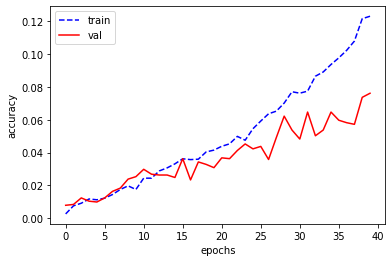

In [ ]:
%%script echo skipping
val_vs_train(train_acc, val_acc, 'accuracy')

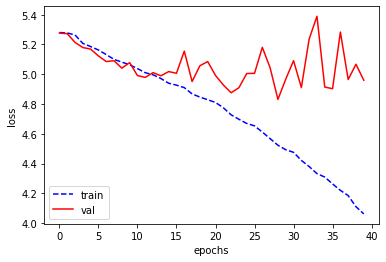

In [ ]:
%%script echo skipping
val_vs_train(train_loss, val_loss, 'loss')

## Net testing stage

Testing our model using downloaded wights, testing without running the train section

Remove the comments to run the model test without training.

In [ ]:
%%script echo skipping
# !pip install --upgrade --no-cache-dir gdown
# !gdown --id 11-wp7sAu-LQmu-Lqm00ZHMV4l1YY2hSJ
# net = CNN2().cuda()
# net.load_state_dict(torch.load('CNN2Model.pt'))
# net.eval()
# net.cuda()

In [ ]:
%%script echo skipping
correct = 0
total = 0

test_acc = []
test_samples = []
i = 1

test_preds = []
true_labels = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()

        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        test_preds.append(predicted.cpu().numpy())
        true_labels.append(labels.cpu().numpy())

        if i%10 == 0:
          test_acc.append(100 * correct / total)
          test_samples.append(i * batchsize)
        i += 1
    test_acc.append(100 * correct / total)
    test_samples.append(i * batchsize)

    y_pred = np.concatenate(test_preds)
    y_true = np.concatenate(true_labels)


print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 7 %


## Our visual result of the test

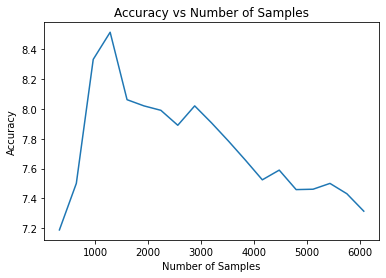

In [ ]:
%%script echo skipping
plt.plot(test_samples, test_acc)
plt.xlabel('Number of Samples')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Samples')
plt.show()

## How our model performed

The performance evaluation of the net using several metrics: F1 score, recall, accuracy, and precision score.

In [ ]:
%%script echo skipping
from sklearn.metrics import f1_score

# # Calculate the F1 score
f1 = f1_score(y_true, y_pred,average='macro')

print("F1 score: ", f1)


F1 score:  0.06435877901316961


In [ ]:
%%script echo skipping
from sklearn.metrics import recall_score

# Calculate the recall score
recall = recall_score(y_true, y_pred,average='macro')

print("Recall score: ", recall)


Recall score:  0.07413253042073067


In [ ]:
%%script echo skipping
from sklearn.metrics import precision_score

# Calculate the precision score
precision = precision_score(y_true, y_pred,average='macro')

print("Precision score: ", precision)


Precision score:  0.09253648648845048


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
%%script echo skipping
from sklearn.metrics import accuracy_score

# Calculate the accuracy score
accuracy = accuracy_score(y_true, y_pred)

print("Accuracy score: ", accuracy)


Accuracy score:  0.07313432835820896


## How our decisions affected the model

The adoption of an increased learning rate has proved effective in addressing the issue of overfitting to the training dataset, although falling short of the desired accuracy levels. Furthermore, the incorporation of an enhanced image size has yielded a superior outcome as compared to the initial experiment.

## Comparison between our models

In [ ]:
%%script echo skipping
Train_final_accuracy = train_acc[-1]
Val_final_accuracy = val_acc[-1]
Test_final_accuracy = accuracy

Model2 = [Train_final_accuracy,Val_final_accuracy,Test_final_accuracy]

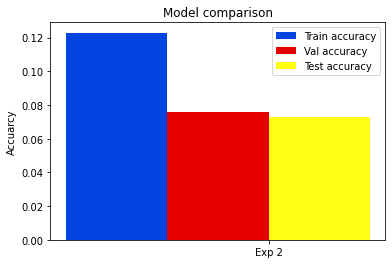

In [ ]:
%%script echo skipping
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()

Models = ['Exp 2']
x = np.arange(len(Models))

width = 5

ax.bar(x - 3*width/2, Model2[0], width, label='Train accuracy', color='#0343df')
ax.bar(x - width/2, Model2[1], width, label='Val accuracy', color='#e50000')
ax.bar(x + width/2, Model2[2], width, label='Test accuracy', color='#ffff14')

ax.set_ylabel('Accuarcy')
ax.set_title('Model comparison')
ax.set_xticks(x)
ax.set_xticklabels(Models, rotation='horizontal')
ax.legend()

plt.show()

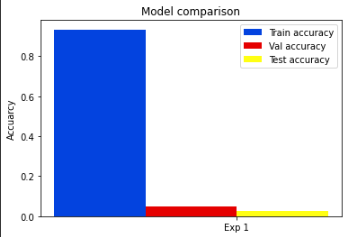

As is evident from the results, the second model has achieved a higher level of success across the train, validation, and test sets.

# Experiment 3 - 4 layers, dropouts, sigmoind activation function

## Introduction to the experiment

The primary objective of the present experiment is to achieve the desired outcome by incorporating the sigmoid activation function, implementing dropout techniques, and increasing the learning rate within the neural network model.

## Pre-processing our data

### Data augmentation

In [ ]:
%%script echo skipping
transform_train = transforms.Compose([
    transforms.Resize((320, 320,)),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.ColorJitter(0,0.3),
    transforms.RandomResizedCrop(320),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((320, 320,)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


### importing dataset and appling transformation


In [ ]:
%%script echo skipping
trainset = torchvision.datasets.StanfordCars(root='./data', split='train', download=True, transform=transform_train)
testset = torchvision.datasets.StanfordCars(root='./data', split='test', download=True, transform=transform_test)

  0%|          | 0/330960 [00:00<?, ?it/s]

Extracting data/stanford_cars/car_devkit.tgz to data/stanford_cars


  0%|          | 0/979269282 [00:00<?, ?it/s]

Extracting data/stanford_cars/cars_train.tgz to data/stanford_cars
Using downloaded and verified file: data/stanford_cars/car_devkit.tgz
Extracting data/stanford_cars/car_devkit.tgz to data/stanford_cars


  0%|          | 0/977350468 [00:00<?, ?it/s]

Extracting data/stanford_cars/cars_test.tgz to data/stanford_cars


  0%|          | 0/185758 [00:00<?, ?it/s]

In [ ]:
%%script echo skipping
datasets = test_split_to_validation(testset)

testset = datasets['test']
valset = datasets['val']

In [ ]:
%%script echo skipping
batchsize = 32

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,
                                          shuffle=True)

valloader = torch.utils.data.DataLoader(valset, batch_size=batchsize,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize,
                                         shuffle=False)

## Net architecture

The architecture depicted above consists of 4 convolutional layers interspersed with relu and sigmoid activation functions, in conjunction with max pooling and dropout techniques.

In [ ]:
%%script echo skipping
class CNN3(nn.Module):

    def __init__(self):
        super().__init__()

        self.Convolution1 = nn.Conv2d(3, 16, kernel_size=2, stride=1, padding=1)
        self.Convolution2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.Convolution3 = nn.Conv2d(32, 64, kernel_size=2, stride=1, padding=1)
        self.Convolution4 = nn.Conv2d(64, 128, kernel_size=2, stride=1, padding=1)

        self.MaxPooling = nn.MaxPool2d(kernel_size=2, stride=2)

        self.FullyConnected1 = nn.Linear(51200, 2048) # 128 x 20 x 20 = 51200
        self.FullyConnected2 = nn.Linear(2048, 1024)
        self.FullyConnected3 = nn.Linear(1024, 512)
        self.FullyConnected4 = nn.Linear(512, 196)

        self.ReLU = nn.ReLU()
        self.Sigmoind = nn.Sigmoid()

        self.Dropout1 = nn.Dropout(0.01)
        self.Dropout3 = nn.Dropout(0.03)
        self.Dropout5 = nn.Dropout(0.05)

    def forward(self, x):
        x = self.ReLU(self.Convolution1(x))
        x = self.Dropout1(x)
        x = self.MaxPooling(x)
        x = self.Sigmoind(self.Convolution2(x))
        x = self.Dropout3(x)
        x = self.MaxPooling(x)
        x = self.ReLU(self.Convolution3(x))
        x = self.Dropout5(x)
        x = self.MaxPooling(x)
        x = self.ReLU(self.Convolution4(x))
        x = self.MaxPooling(x)
        x = torch.flatten(x,1)
        x = self.ReLU(self.FullyConnected1(x))
        x = self.ReLU(self.FullyConnected2(x))
        x = self.ReLU(self.FullyConnected3(x))
        x = self.FullyConnected4(x)
        return x




In [ ]:
%%script echo skipping
net = CNN3().cuda()
print(net)

CNN3(
  (Convolution1): Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (Convolution2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Convolution3): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (Convolution4): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (MaxPooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (FullyConnected1): Linear(in_features=51200, out_features=2048, bias=True)
  (FullyConnected2): Linear(in_features=2048, out_features=1024, bias=True)
  (FullyConnected3): Linear(in_features=1024, out_features=512, bias=True)
  (FullyConnected4): Linear(in_features=512, out_features=196, bias=True)
  (ReLU): ReLU()
  (Sigmoind): Sigmoid()
  (Dropout1): Dropout(p=0.01, inplace=False)
  (Dropout3): Dropout(p=0.03, inplace=False)
  (Dropout5): Dropout(p=0.05, inplace=False)
)


## Net hyper parameters

In [ ]:
%%script echo skipping
criterion = nn.CrossEntropyLoss()

In [ ]:
%%script echo skipping
optimizer = torch.optim.SGD(net.parameters(), lr=0.03, momentum=0.8)

## Net training stage

In [ ]:
%%script echo skipping
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%script echo skipping
max_acc = 0

train_loss = []
train_acc = []

val_loss = []
val_acc = []

epochs = 35

for epoch in tqdm(range(epochs)):

    train_running_loss = 0.0
    train_running_corrects = 0

    val_running_loss = 0.0
    val_running_corrects = 0

    net.train()
    for i, data in enumerate(trainloader, 0):

        inputs, labels = data

        inputs = inputs.cuda()
        labels = labels.cuda()


        optimizer.zero_grad()


        outputs = net(inputs)

        _, preds = torch.max(outputs, 1)
        train_running_corrects += torch.sum(preds == labels.data)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_running_loss += (loss.item())

    net.eval()
    with torch.no_grad():
      for i, data in enumerate(valloader, 0):

          inputs, labels = data

          inputs = inputs.cuda()
          labels = labels.cuda()


          optimizer.zero_grad()


          outputs = net(inputs)

          _, preds = torch.max(outputs, 1)
          val_running_corrects += torch.sum(preds == labels.data)

          loss = criterion(outputs, labels)

          val_running_loss += (loss.item())


    train_loss.append(train_running_loss/len(trainloader))
    epoch_train_acc = train_running_corrects.double() / len(trainset)
    train_acc.append(epoch_train_acc.item())


    val_loss.append(val_running_loss/len(valloader))
    epoch_val_acc = val_running_corrects.double() / len(valset)
    val_acc.append(epoch_val_acc.item())

        # deep copy the model (Early Stopping) and Saving our model, when we get best accuracy
    if epoch_val_acc.item() > max_acc:
        max_acc = epoch_val_acc.item()
        current_best_model = copy.deepcopy(net.state_dict())
        path = "/content/drive/MyDrive/CNN3Model.pt"
        torch.save(net.state_dict(), path)

    print('')
    print('epoch number:',epoch)
    print('Train acc:',epoch_train_acc.item(), ' Train loss:',train_running_loss/len(trainloader))
    print('Val acc:',epoch_val_acc.item(), ' Val loss:',val_running_loss/len(valloader))

net.load_state_dict(current_best_model)
print('Finished Training')

  3%|▎         | 1/35 [03:37<2:03:20, 217.66s/it]


epoch number: 0
Train acc: 0.005648330058939096  Train loss: 5.28079485799752
Val acc: 0.0069617105917453995  Val loss: 5.277072853512234


  6%|▌         | 2/35 [06:54<1:52:59, 205.45s/it]


epoch number: 1
Train acc: 0.008349705304518663  Train loss: 5.278369699739942
Val acc: 0.0069617105917453995  Val loss: 5.27523564535474


  9%|▊         | 3/35 [10:09<1:47:05, 200.80s/it]


epoch number: 2
Train acc: 0.008349705304518663  Train loss: 5.2773703444237805
Val acc: 0.0069617105917453995  Val loss: 5.274099425664024


 11%|█▏        | 4/35 [13:25<1:42:42, 198.79s/it]


epoch number: 3
Train acc: 0.008349705304518663  Train loss: 5.27658104429058
Val acc: 0.0069617105917453995  Val loss: 5.273339036911253


 14%|█▍        | 5/35 [16:39<1:38:34, 197.16s/it]


epoch number: 4
Train acc: 0.008349705304518663  Train loss: 5.276274600683474
Val acc: 0.0069617105917453995  Val loss: 5.272850937313503


 17%|█▋        | 6/35 [19:52<1:34:31, 195.56s/it]


epoch number: 5
Train acc: 0.008349705304518663  Train loss: 5.275932383069805
Val acc: 0.0069617105917453995  Val loss: 5.272588245452396


 20%|██        | 7/35 [23:05<1:30:49, 194.64s/it]


epoch number: 6
Train acc: 0.008349705304518663  Train loss: 5.27575433955473
Val acc: 0.0069617105917453995  Val loss: 5.272223608834403


 23%|██▎       | 8/35 [26:17<1:27:13, 193.84s/it]


epoch number: 7
Train acc: 0.008349705304518663  Train loss: 5.275471904231053
Val acc: 0.0069617105917453995  Val loss: 5.272081821683853


 26%|██▌       | 9/35 [29:32<1:24:13, 194.35s/it]


epoch number: 8
Train acc: 0.008349705304518663  Train loss: 5.2754403918397195
Val acc: 0.0069617105917453995  Val loss: 5.272036196693541


 29%|██▊       | 10/35 [32:47<1:21:05, 194.60s/it]


epoch number: 9
Train acc: 0.008349705304518663  Train loss: 5.275455598270192
Val acc: 0.0069617105917453995  Val loss: 5.271820325700063


 31%|███▏      | 11/35 [36:01<1:17:46, 194.46s/it]


epoch number: 10
Train acc: 0.008349705304518663  Train loss: 5.275394695880366
Val acc: 0.0069617105917453995  Val loss: 5.2717652850680885


 34%|███▍      | 12/35 [39:15<1:14:23, 194.05s/it]


epoch number: 11
Train acc: 0.008349705304518663  Train loss: 5.275311498080983
Val acc: 0.0069617105917453995  Val loss: 5.27186772179982


 37%|███▋      | 13/35 [42:29<1:11:12, 194.19s/it]


epoch number: 12
Train acc: 0.008349705304518663  Train loss: 5.275399318395876
Val acc: 0.0069617105917453995  Val loss: 5.27178234524197


 40%|████      | 14/35 [45:43<1:07:54, 194.03s/it]


epoch number: 13
Train acc: 0.008349705304518663  Train loss: 5.275076853060255
Val acc: 0.0069617105917453995  Val loss: 5.271613060481965


 43%|████▎     | 15/35 [48:56<1:04:37, 193.85s/it]


epoch number: 14
Train acc: 0.008349705304518663  Train loss: 5.2749147676954085
Val acc: 0.0069617105917453995  Val loss: 5.27137273455423


 46%|████▌     | 16/35 [52:13<1:01:37, 194.62s/it]


epoch number: 15
Train acc: 0.008349705304518663  Train loss: 5.2747867191539095
Val acc: 0.0069617105917453995  Val loss: 5.271037404499356


 49%|████▊     | 17/35 [55:27<58:21, 194.55s/it]  


epoch number: 16
Train acc: 0.008349705304518663  Train loss: 5.2741549248788875
Val acc: 0.0069617105917453995  Val loss: 5.269928023928688


 51%|█████▏    | 18/35 [58:39<54:52, 193.67s/it]


epoch number: 17
Train acc: 0.008349705304518663  Train loss: 5.272273078619265
Val acc: 0.0069617105917453995  Val loss: 5.2628825884016734


 54%|█████▍    | 19/35 [1:01:51<51:35, 193.46s/it]


epoch number: 18
Train acc: 0.009945972495088409  Train loss: 5.257607071072448
Val acc: 0.0104425658876181  Val loss: 5.2278306143624445


 57%|█████▋    | 20/35 [1:05:06<48:26, 193.76s/it]


epoch number: 19
Train acc: 0.011542239685658153  Train loss: 5.206597713395661
Val acc: 0.01342615614122327  Val loss: 5.171960043528723


 60%|██████    | 21/35 [1:08:18<45:04, 193.19s/it]


epoch number: 20
Train acc: 0.01092829076620825  Train loss: 5.183120344199386
Val acc: 0.010939830929885628  Val loss: 5.1346540451049805


 63%|██████▎   | 22/35 [1:11:27<41:35, 191.98s/it]


epoch number: 21
Train acc: 0.011542239685658153  Train loss: 5.169800212336521
Val acc: 0.011437095972153156  Val loss: 5.120146448650058


 66%|██████▌   | 23/35 [1:14:39<38:25, 192.14s/it]


epoch number: 22
Train acc: 0.013015717092337916  Train loss: 5.1585686908048745
Val acc: 0.014420686225758327  Val loss: 5.115799881163097


 69%|██████▊   | 24/35 [1:17:54<35:22, 192.94s/it]


epoch number: 23
Train acc: 0.011296660117878192  Train loss: 5.142060085371429
Val acc: 0.016409746394828444  Val loss: 5.091205725594173


 71%|███████▏  | 25/35 [1:21:10<32:16, 193.63s/it]


epoch number: 24
Train acc: 0.013629666011787818  Train loss: 5.129387410481771
Val acc: 0.0243659870711089  Val loss: 5.069684770372179


 74%|███████▍  | 26/35 [1:24:28<29:14, 194.93s/it]


epoch number: 25
Train acc: 0.016453831041257368  Train loss: 5.121737156662286
Val acc: 0.017901541521631027  Val loss: 5.076286262936062


 77%|███████▋  | 27/35 [1:27:44<26:03, 195.49s/it]


epoch number: 26
Train acc: 0.01399803536345776  Train loss: 5.112084917928659
Val acc: 0.025857782197911485  Val loss: 5.0559755431281195


 80%|████████  | 28/35 [1:31:00<22:49, 195.65s/it]


epoch number: 27
Train acc: 0.01424361493123772  Train loss: 5.104776537652109
Val acc: 0.023371456986573842  Val loss: 5.062097821916852


 83%|████████▎ | 29/35 [1:34:15<19:32, 195.47s/it]


epoch number: 28
Train acc: 0.015962671905697445  Train loss: 5.096083953333836
Val acc: 0.019890601690701143  Val loss: 5.04011497043428


 86%|████████▌ | 30/35 [1:37:30<16:16, 195.21s/it]


epoch number: 29
Train acc: 0.01829567779960707  Train loss: 5.0945200284322105
Val acc: 0.01690701143709597  Val loss: 5.038435020144024


 89%|████████▊ | 31/35 [1:40:42<12:56, 194.19s/it]


epoch number: 30
Train acc: 0.016944990176817287  Train loss: 5.07621535506903
Val acc: 0.02486325211337643  Val loss: 5.043849233597044


 91%|█████████▏| 32/35 [1:43:54<09:40, 193.51s/it]


epoch number: 31
Train acc: 0.019155206286836934  Train loss: 5.068407756207036
Val acc: 0.025857782197911485  Val loss: 5.051707055833605


 94%|█████████▍| 33/35 [1:47:05<06:25, 192.80s/it]


epoch number: 32
Train acc: 0.016453831041257368  Train loss: 5.062463395735797
Val acc: 0.02386872202884137  Val loss: 5.0413402981228295


 97%|█████████▋| 34/35 [1:50:17<03:12, 192.59s/it]


epoch number: 33
Train acc: 0.02210216110019646  Train loss: 5.046411910711551
Val acc: 0.02386872202884137  Val loss: 4.997994498601035


100%|██████████| 35/35 [1:53:28<00:00, 194.54s/it]


epoch number: 34
Train acc: 0.023330058939096267  Train loss: 5.024171874102424
Val acc: 0.025360517155643955  Val loss: 5.006915796370733
Finished Training


## Our visual result of the train stage

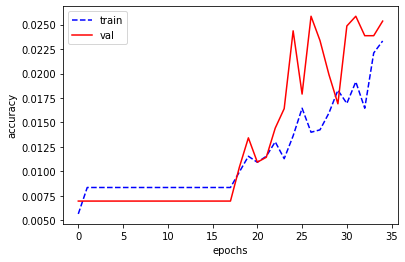

In [ ]:
%%script echo skipping
val_vs_train(train_acc, val_acc, 'accuracy')

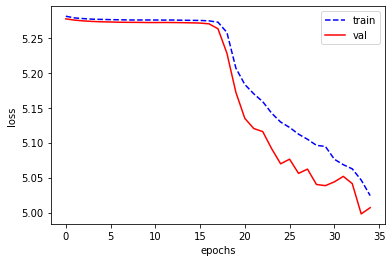

In [ ]:
%%script echo skipping
val_vs_train(train_loss, val_loss, 'loss')

## Net testing stage

Testing our model using downloaded wights, testing without running the train section

Remove the comments to run the model test without training.

In [ ]:
%%script echo skipping
# !pip install --upgrade --no-cache-dir gdown
# !gdown --id 1IIfGNsTcA5HzhGPmeM5GENbeWpEaAKwV
# net = CNN3().cuda()
# net.load_state_dict(torch.load('CNN3Model.pt'))
# net.eval()
# net.cuda()

In [ ]:
%%script echo skipping
correct = 0
total = 0

test_acc = []
test_samples = []
i = 1

test_preds = []
true_labels = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()

        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        test_preds.append(predicted.cpu().numpy())
        true_labels.append(labels.cpu().numpy())

        if i%10 == 0:
          test_acc.append(100 * correct / total)
          test_samples.append(i * batchsize)
        i += 1
    test_acc.append(100 * correct / total)
    test_samples.append(i * batchsize)

    y_pred = np.concatenate(test_preds)
    y_true = np.concatenate(true_labels)


print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 1 %


## Our visual result of the test

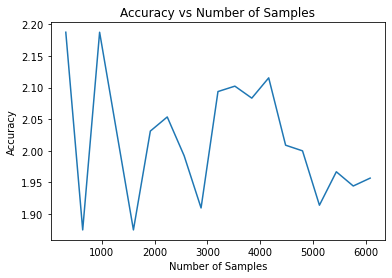

In [ ]:
%%script echo skipping
plt.plot(test_samples, test_acc)
plt.xlabel('Number of Samples')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Samples')
plt.show()

## How our model performed

The performance evaluation of the net using several metrics: F1 score, recall, accuracy, and precision score.

In [ ]:
%%script echo skipping
from sklearn.metrics import f1_score

# # Calculate the F1 score
f1 = f1_score(y_true, y_pred,average='macro')

print("F1 score: ", f1)


F1 score:  0.004942081997867449


In [ ]:
%%script echo skipping
from sklearn.metrics import recall_score

# Calculate the recall score
recall = recall_score(y_true, y_pred,average='macro')

print("Recall score: ", recall)


Recall score:  0.018077789323922802


In [ ]:
%%script echo skipping
from sklearn.metrics import precision_score

# Calculate the precision score
precision = precision_score(y_true, y_pred,average='macro')

print("Precision score: ", precision)


Precision score:  0.0035869223895998534


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
%%script echo skipping
from sklearn.metrics import accuracy_score

# Calculate the accuracy score
accuracy = accuracy_score(y_true, y_pred)

print("Accuracy score: ", accuracy)


Accuracy score:  0.01956882255389718


## How our decisions affected the model

Contrary to initial expectations, the present model has failed to attain the desired outcome, primarily attributable to the incorporation of dropout techniques and the upsurge in learning rate.

## Comparison between our models

In [ ]:
%%script echo skipping
Train_final_accuracy = train_acc[-1]
Val_final_accuracy = val_acc[-1]
Test_final_accuracy = accuracy

Model3 = [Train_final_accuracy,Val_final_accuracy,Test_final_accuracy]

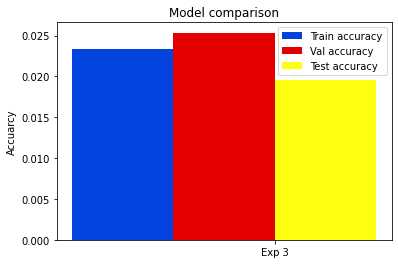

In [ ]:
%%script echo skipping
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()

Models = ['Exp 3']
x = np.arange(len(Models))

width = 5

ax.bar(x - 3*width/2, Model3[0], width, label='Train accuracy', color='#0343df')
ax.bar(x - width/2, Model3[1], width, label='Val accuracy', color='#e50000')
ax.bar(x + width/2, Model3[2], width, label='Test accuracy', color='#ffff14')

ax.set_ylabel('Accuarcy')
ax.set_title('Model comparison')
ax.set_xticks(x)
ax.set_xticklabels(Models, rotation='horizontal')
ax.legend()

plt.show()

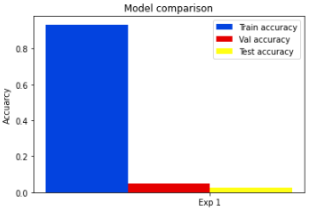

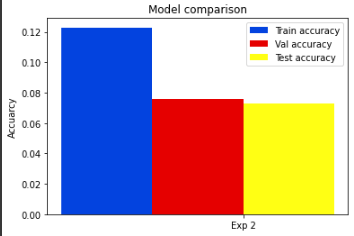

As is evident from the results, the third model did not yield the most favorable outcomes as compared to the other models. Nevertheless, it came in close proximity to the first model in terms of validation and test accuracy.

# Optimal Model, testing environment

## Model loading

Loading the net from the second experiment - run CNN2 model before running the following code

In [ ]:
!pip install --upgrade --no-cache-dir gdown
!gdown --id 11-wp7sAu-LQmu-Lqm00ZHMV4l1YY2hSJ
net = CNN2().cuda()
net.load_state_dict(torch.load('CNN2Model.pt'))
net.eval()
net.cuda()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=11-wp7sAu-LQmu-Lqm00ZHMV4l1YY2hSJ
To: /content/CNN2Model.pt
100% 345M/345M [00:08<00:00, 42.1MB/s]


CNN2(
  (Convolution1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Convolution2): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (Convolution3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Convolution4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (MaxPooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (FullyConnected1): Linear(in_features=41472, out_features=2048, bias=True)
  (FullyConnected2): Linear(in_features=2048, out_features=512, bias=True)
  (FullyConnected3): Linear(in_features=512, out_features=196, bias=True)
  (ReLU): ReLU()
)

## Singal image test for our best model

In [ ]:
uploaded_file = files.upload()

Saving benz.jpg to benz.jpg


In [ ]:

img = Image.open(list(uploaded_file.keys())[0])
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((300, 300,)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
img = transform(img)

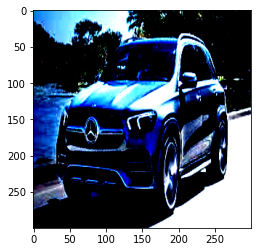

In [ ]:
plt.imshow(img.permute(1,2,0), cmap='gray')
plt.show()

## Prediction of the singal image

In [ ]:
prediction = net(img.unsqueeze(0).cuda())
prediction = torch.argmax(prediction).item()
print('Our model classify this image as:',prediction)

Our model classify this image as: 148
